### Лабораторна робота №4, Штучний інтелект в задачах обробки зображень
**Виконав**: студент групи ІП-11, Лошак Віктор Іванович<br>
**Перевірив**: Професор кафедри ІСТ ФІОТ, Нікітін В.А.<br>

**Тема роботи**: Розпізнавання людини на фото з використанням бібліотеки Dlib<br>
**Мета роботи**: Навчитися розпізнавати обличчя на фото використовуючи навчені нейронні мережі

21.03.2024

**Завдання**:<br>
1.	Зробити розпізнавання будь-якої “зірки”;
2.	Зробити розпізнавання себе.

**Task**:<br>
1. Identify face of any "star";
2. Make self-recognition.

In [55]:
import dlib
from glob import glob 
import cv2
import numpy as np
import os
import pickle
import shutil
import matplotlib.pyplot as plt

In [56]:
# load the face detector, landmark predictor, and face recognition model
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
face_encoder = dlib.face_recognition_model_v1("models/dlib_face_recognition_resnet_model_v1.dat")

VALID_EXTENSIONS = ['.png', '.jpg', '.jpeg']

root_dir = "data"
class_names = os.listdir(root_dir)

Counting the amount of images of each class

In [57]:
person_image_count = {}

for class_name in class_names:
    class_dir = os.path.sep.join([root_dir, class_name])
    class_file_paths = glob(os.path.sep.join([class_dir, '*.*']))
    person_image_count[class_name] = len(class_file_paths)
    
sorted_person_image_count = dict(sorted(person_image_count.items(), key=lambda x: x[1], reverse=True))
sorted_person_image_count
    

{'Luiz_Inacio_Lula_da_Silva': 48, 'Viktor': 17}

Let's classify the images of Luiz_Inacio_Lula_da_Silva because he has a very long name and normal amount of available images

In [58]:

# for class_name in class_names:
#     if class_name != "Luiz_Inacio_Lula_da_Silva":
#         class_dir = os.path.join(root_dir, class_name)
#         shutil.rmtree(class_dir)

In [59]:
def get_image_paths(root_dir, class_names):
    """ grab the paths to the images in our dataset"""
    image_paths = []

    for class_name in class_names:
        class_dir = os.path.sep.join([root_dir, class_name])
        class_file_paths = glob(os.path.sep.join([class_dir, '*.*']))

        for file_path in class_file_paths:
            # extract the file extension of the current file
            ext = os.path.splitext(file_path)[1]

            if ext.lower() not in VALID_EXTENSIONS:
                print("Skipping file: {}".format(file_path))
                continue

            image_paths.append(file_path)

    return image_paths

Preprocessing of the images

In [60]:
def face_rects(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = face_detector(gray, 1)
    # return the bounding boxes
    return rects


Extracting the landmarks of the face.

In [61]:

def face_landmarks(image):
    return [shape_predictor(image, face_rect) for face_rect in face_rects(image)]


In [62]:

def face_encodings(image):
    # compute the facial embeddings for each face 
    # function returns a 128-d vector that describes the face in an image
    return [np.array(face_encoder.compute_face_descriptor(image, face_landmark)) 
            for face_landmark in face_landmarks(image)]
    


Compute the euclidean distance between the current face encoding and all the face encodings in the databas

In [63]:
def nb_of_matches(known_encodings, unknown_encoding):
    distances = np.linalg.norm(known_encodings - unknown_encoding, axis=1)
    small_distances = distances <= 0.6
    # return the number of matches
    return sum(small_distances)

In [ ]:
image_paths = get_image_paths(root_dir, class_names)
name_encondings_dict = {}

nb_current_image = 1
# now we can loop over the image paths, locate the faces, and encode them
for image_path in image_paths:
    print(f"Image processed {nb_current_image}/{len(image_paths)}")
    image = cv2.imread(image_path)
    
    encodings = face_encodings(image)
    # get the name from the image path
    name = image_path.split(os.path.sep)[-2]    
    name_encondings_dict.setdefault(name, []).extend(encodings)
    nb_current_image += 1

with open("encodings.pickle", "wb") as f:
    pickle.dump(name_encondings_dict, f)

Load and resize the image

In [88]:
with open("encodings.pickle", "rb") as f:
    name_encodings_dict = pickle.load(f)

image = cv2.imread(r"example\cillian.jpg")
window_width = 500
window_height = 500

original_height, original_width = image.shape[:2]

width_ratio = window_width / original_width
height_ratio = window_height / original_height

ratio = min(width_ratio, height_ratio)
new_width = int(original_width * ratio)
new_height = int(original_height * ratio)
image = cv2.resize(image, (new_width, new_height))

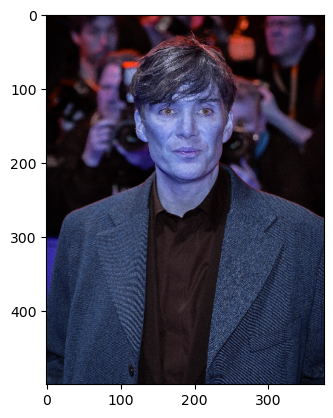

In [89]:
plt.imshow(image)

In [75]:
len(name_encodings_dict["Viktor"])

19

Do the classification

In [90]:

encodings = face_encodings(image)
# print(len(encodings))
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2.imshow("image", gray)
# # detect faces in the grayscale image
# rects = face_detector(gray, 1)
# print(len(rects))

names = []

for encoding in encodings:
    # initialize a dictionary to store the name of the 
    # person and the number of times it was matched
    counts = {}
    for (name, encodings) in name_encodings_dict.items():
        # compute the number of matches between the current encoding and the encodings 
        # of the known faces and store the number of matches in the dictionary
        counts[name] = nb_of_matches(encodings, encoding)
    
    print(len(counts))
    for name, count in counts.items():
        print(f"{name}: {count}")
    
    if all(count == 0 for count in counts.values()):
        name = "Unknown"
    else:
        name = max(counts, key=counts.get)

    names.append(name)
    
# draw the bounding box of the face along with the name of the person
for rect, name in zip(face_rects(image), names):
    x1, y1, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, name, (x1, y1 - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

2
Luiz_Inacio_Lula_da_Silva: 0
Viktor: 0
2
Luiz_Inacio_Lula_da_Silva: 1
Viktor: 0


**Питання**:<br>
1. Що таке розпізнавання обличчя?
2. Які кроки для розпізнвання обличчя?
3. Що таке згорткова нейронна мережа?
4. Як відбувається навчання мережі?
5. Що таке dlib?

**Відповіді**:<br>
1. Розпізнавання обличчя - це технологія комп'ютерного зору, яка ідентифікує або верифікує особу на зображенні або відео шляхом порівняння та аналізу шаблонів обличчя.
2. Кроки для розпізнавання обличчя зазвичай включають: виявлення обличчя на зображенні, витягування ознак обличчя, порівняння ознак із базою даних обличь та ідентифікацію або верифікацію обличчя.
3. Згорткова нейронна мережа (Convolutional Neural Network, CNN) - це клас глибоких нейронних мереж, що широко застосовуються у задачах комп'ютерного зору для аналізу візуальних образів, завдяки своїй здатності автоматично та ефективно витягувати ознаки з зображень.
4. Навчання мережі відбувається шляхом подачі на вхід набору зображень з відомими відповідями (мітками), коригування вагів нейронів на основі розбіжностей між прогнозами мережі та реальними відповідями, з метою мінімізації помилки прогнозування.
5. Dlib - це відкрита бібліотека на мові програмування C++, яка містить широкий спектр інструментів для розробки програмного забезпечення у таких областях, як машинне навчання, обробка зображень, графіка, бази даних, інтерфейси користувача та інше, включаючи засоби для розпізнавання обличчя.
